In [2]:
import pandas as pd 
#pd.set_option('display.max_colwidth', -1) #show whole tweets
import numpy as np
from matplotlib import pyplot as plt
import math

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import gensim
from gensim import corpora, models


[nltk_data] Downloading package punkt to /home/victor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Chargement des données

In [3]:
df = pd.read_csv("../../data/extraction_twint/tweets_data/data_service_clients/with_reply_time/wholefoods.csv").filter(["tweet","reply_time"])

#reply time to timedelta
df['reply_time']=df['reply_time'].map(pd.to_timedelta)

#reply time in minutes
df['reply_time']=df['reply_time'].map(lambda x: x.days*1440 + x.seconds//60)

df.head(15)

,tweet,reply_time
0,#DAM job opening - Senior Marketing Asset Mana...,NaN
1,"Finally, a holiday I can totally support. I'll...",NaN
2,@3rdHourTODAY please mention that there are op...,NaN
3,"Riddle me this, Whole Foods. How the hell is M...",NaN
4,NEW: Enjoy #Austin Ice Skating on @WholeFoods ...,NaN
5,"Now through December 17, donate to @WholeFoods...",NaN
6,So this is fake news,NaN
7,great! i usually can rely on Fresh Pond. it’s ...,NaN
8,is it not discontinued? —i’ve been looking for...,11.0
9,#GivingTuesday may be over - but the need is s...,NaN


# 2. Premières observations

### Proportions de tweets avec/sans réponse

In [4]:
df['has_reply'] = df['reply_time'].map(lambda x : not(math.isnan(x)))

counts=df['has_reply'].value_counts()/has_reply.size*100
plot = counts.plot.pie(y='has_reply', figsize=(5, 5), legend=True)

NameError: name 'has_reply' is not defined

In [ ]:
df[df.has_reply==True].head(30)

### Temps de réponse en jours

(array([1.656e+03, 3.940e+02, 1.010e+02, 4.100e+01, 3.900e+01, 1.700e+01,
        7.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 <a list of 19 Patch objects>)

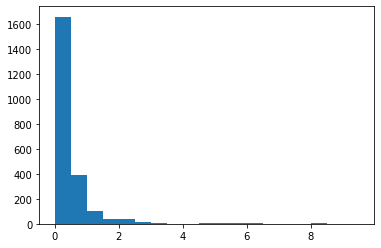

In [5]:
plt.hist(df['reply_time']/1440.0, np.arange(0,10,0.5))

### Temps de réponse en minutes

(array([ 26., 112., 127., 129., 115.,  87.,  87.,  53.,  43.,  29.,  27.,
         31.,  27.,  21.,  21.,  20.,   8.,   8.,   6.,   6.,  10.,   7.,
          9.,  10.,   7.,   5.,   7.,   8.,   6.,   8.,   4.,   6.,   8.,
          7.,   4.,   2.,   3.,   2.,   0.,   5.,   3.,   1.,   3.,   6.,
          1.,   4.,   0.,   0.,   0.,   2.,   2.,   2.,   4.,   2.,   3.,
          3.,   2.,   1.,   1.,   2.,   4.,   2.,   2.,   3.,   2.,   0.,
          0.,   1.,   2.,   1.,   2.,   2.,   2.,   1.,   0.,   4.,   1.,
          3.,   0.,   1.,   2.,   2.,   2.,   2.,   2.,   1.,   1.,   0.,
          3.,   2.,   0.,   0.,   2.,   2.,   0.,   1.,   1.,   0.,   1.,
          1.,   1.,   0.,   0.,   3.,   0.,   1.,   1.,   0.,   2.,   2.,
          0.,   1.,   1.,   2.,   2.,   6.,   4.,   1.,   0.,   1.,   2.,
          2.,   2.,   1.,   1.,   2.,   1.,   1.,   0.,   1.,   2.,   2.,
          1.,   3.,   2.,   0.,   1.,   1.,   0.,   2.,   2.,   1.,   0.,
          1.,   0.,   3.,   2.,   2., 

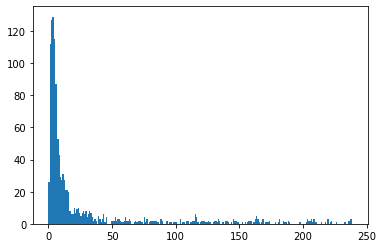

In [6]:
plt.hist(df['reply_time'], np.arange(0,240,1))

# 3. Pré-traitement

In [7]:
sample = df['tweet']

##on enlève les valeurs nulles
sample = sample.dropna()

sample.head()

0    #DAM job opening - Senior Marketing Asset Mana...
1    Finally, a holiday I can totally support. I'll...
2    @3rdHourTODAY please mention that there are op...
3    Riddle me this, Whole Foods. How the hell is M...
4    NEW: Enjoy #Austin Ice Skating on @WholeFoods ...
Name: tweet, dtype: object

In [8]:
##on tokenise les phrases
sample=sample.map(lambda x: nltk.tokenize.word_tokenize(x))

In [9]:
##liste de stopwords
stop_words = stopwords.words('english')

##on supprime les stopwords
sample = sample.apply(lambda x: [item for item in x if item not in stop_words])
sample.head()

0    [#, DAM, job, opening, -, Senior, Marketing, A...
1    [Finally, ,, holiday, I, totally, support, ., ...
2    [@, 3rdHourTODAY, please, mention, options, ha...
3    [Riddle, ,, Whole, Foods, ., How, hell, Mitch,...
4    [NEW, :, Enjoy, #, Austin, Ice, Skating, @, Wh...
Name: tweet, dtype: object

In [10]:
##to be improved or skipped
stemmer = PorterStemmer()

sample=sample.apply(lambda x: [stemmer.stem(item) for item in x])
sample.head(12)

0     [#, dam, job, open, -, senior, market, asset, ...
1     [final, ,, holiday, I, total, support, ., I, '...
2     [@, 3rdhourtoday, pleas, mention, option, hair...
3     [riddl, ,, whole, food, ., how, hell, mitch, m...
4     [new, :, enjoy, #, austin, ice, skate, @, whol...
5     [now, decemb, 17, ,, donat, @, wholefood, #, f...
6                                      [So, fake, news]
7     [great, !, usual, reli, fresh, pond, ., ’, fav...
8     [discontinu, ?, —i, ’, look, !, look, four, di...
9     [#, givingtuesday, may, -, need, still, strong...
10    [🔝👀🇮🇱🏁, @, cityattorneyla, @, laciti, vs, @, c...
11    [would, love, see, whole, food, trader, joe, ’...
Name: tweet, dtype: object

# 4. Bag of words

In [20]:

##remove links
def preprocessor(tweet):
    words=[]
    for w in tweet.split(" "):
        if not(w.startswith("http") or w.startswith("www") or w.startswith("pic.twitter")):
            words+=[w]
    return ' '.join(words).lower()


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

matrix = TfidfVectorizer(max_features=1000, preprocessor=preprocessor, token_pattern=r"(?u)\b\w\w+\b|!|\?", min_df=0.005, stop_words="english")
#matrix = CountVectorizer(max_features=5000, token_pattern=r"(?u)\b\w\w+\b|!|\?", stop_words="english")

X = matrix.fit_transform(df['tweet']).toarray()

matrix.get_feature_names()

#matrix.inverse_transform(X)

['!',
 '10',
 '20',
 '2019',
 '2020',
 '30',
 '?',
 'actually',
 'affiliated',
 'affiliation',
 'amazing',
 'amazon',
 'area',
 'aren',
 'article',
 'available',
 'away',
 'awesome',
 'bad',
 'bag',
 'bags',
 'bar',
 'based',
 'believe',
 'benefits',
 'best',
 'better',
 'bezos',
 'big',
 'bought',
 'boulderorganic',
 'boycott',
 'boycottwholefoods',
 'brand',
 'bread',
 'bring',
 'business',
 'buy',
 'buying',
 'care',
 'chain',
 'change',
 'check',
 'cheese',
 'chicken',
 'city',
 'come',
 'companies',
 'company',
 'customer',
 'customers',
 'cut',
 'day',
 'days',
 'delicious',
 'delivery',
 'did',
 'didn',
 'different',
 'dinner',
 'does',
 'doesn',
 'doing',
 'don',
 'drinking',
 'eat',
 'eating',
 'employees',
 'end',
 'family',
 'favorite',
 'feel',
 'finally',
 'flavors',
 'food',
 'foods',
 'free',
 'freewill',
 'fresh',
 'friends',
 'fuck',
 'getting',
 'giving',
 'glad',
 'going',
 'good',
 'got',
 'gotitfree',
 'great',
 'groceries',
 'grocery',
 'guess',
 'guys',
 'happy',

In [22]:
y = df.has_reply

# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
# Naive Bayes 
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(class_weight='balanced')

classifier.fit(X_train, y_train)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
# Predict Class
y_pred = classifier.predict(X_test)

# 5. Résultats

**Objectif :** Avoir un recall le plus élevé possible (on ne doit pas manquer de tweets urgents) tout en gardant une précision correcte

No handles with labels found to put in legend.


RESULTATS 
          Accuracy : 79.26% 
 Balanced Accuracy : 52.61% 
          F1 score : 0.1655
         Precision : 26.97% (how many selected items are relevant)
            Recall : 11.94% (how many relevant items are selected)
 

STATISTICS
 Proportion of positives in test set    : 17.22%
 Proportion of positives in predictions : 7.63%


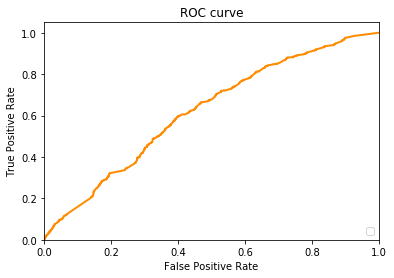

In [25]:
from sklearn.metrics import *

## PRINT SCORES

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

f1_score = f1_score(y_test, y_pred)
precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)


string = "RESULTATS \n \
         Accuracy : {accuracy}% \n \
Balanced Accuracy : {balanced_accuracy}% \n \
         F1 score : {f1_score}\n \
        Precision : {precision}% (how many selected items are relevant)\n \
           Recall : {recall}% (how many relevant items are selected)\n \
\n\n\
STATISTICS\n\
 Proportion of positives in test set    : {positives}%\n\
 Proportion of positives in predictions : {predicted_positives}%\
"

print(string.format(accuracy = round(100*accuracy,2),
                    balanced_accuracy = round(100*balanced_accuracy,2),
                    f1_score = round(f1_score,4), 
                    precision = round(100*precision_score,2), 
                    recall = round(100*recall_score,2),
                    positives = round(100*y_test.sum()/len(y_test),2),
                    predicted_positives = round(100*y_pred.sum()/len(y_pred),2),
                   ))


## DISPLAY ROC CURVE
roc_curve = roc_curve(y_test, classifier.predict_proba(X_test)[:, 1])

plt.plot(roc_curve[0], roc_curve[1], color='darkorange',
         lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()         

Confusion matrix, without normalization
[[2703  195]
 [ 531   72]]
Normalized confusion matrix
[[0.93271222 0.06728778]
 [0.88059701 0.11940299]]


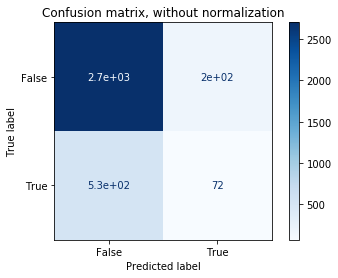

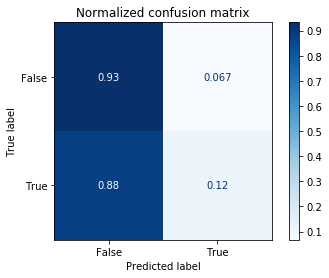

In [26]:
# CONFUSION MATRIX
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [31]:
matrix.vocabulary_['?']

20

In [34]:

m = CountVectorizer(max_features=10000, token_pattern=r"(?u)\b\w\w+\b|!|\?")
text=["","bonjour? e je suis victor"]
x = m.fit_transform(text).toarray()
m.vocabulary_

{'bonjour': 1, '?': 0, 'je': 2, 'suis': 3, 'victor': 4}